In [1]:
%matplotlib inline
#matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set_context("talk")

# Keras
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Scikit Learn
from sklearn.model_selection import StratifiedKFold, LeaveOneOut
from sklearn.metrics import confusion_matrix

# others
import pandas as pd
import numpy as np
import pickle as pkl
import uuid

Using TensorFlow backend.
/home/fferreira/.pyenv/versions/3.7.2/envs/pleural/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/fferreira/.pyenv/versions/3.7.2/envs/pleural/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/fferreira/.pyenv/versions/3.7.2/envs/pleural/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype

In [2]:
df = pkl.load(open('df_norm_exams.pkl', 'rb'))
data = {
    'output': df['diagnostico'],
    'normalized': df.loc[:,  df.columns != 'diagnostico']
}

In [3]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    im = ax.matshow(cm, cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           #yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, 
           #yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')


    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i , format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    ax.set_yticklabels([''] + classes)

    return ax


In [4]:
"""
Classes for performing the NN training.
"""

import warnings
warnings.filterwarnings('always')

def sp(y_true, y_pred, cut=0.):
    false_output_idx = np.where(y_pred < cut)
    output= np.ones(y_pred.shape)
    output[false_output_idx] = -1
    output = output.T[0]
    cm_ = confusion_matrix(y_true, output)
    cm_ = cm_.astype('float') / cm_.sum(axis=1)[:, np.newaxis]
    if cm_.shape[0] != 1:
        no_class_prob, class_prob = cm_.diagonal()
    else:
        # For the leaveOneOut case
        no_class_prob, class_prob = cm_[0], cm_[0]
    geometric_mean = np.sqrt(no_class_prob * class_prob)
    mean = np.mean([no_class_prob, class_prob])
    SP = np.sqrt(geometric_mean * mean)
    return SP


def sp_max(y_true, y_pred):
    cuts = np.arange(-1., 1., .05)
    sps = [sp(y_true, y_pred, cut)
           for cut in cuts]
    sp_max = np.max(sps)
    sp_max_cut = np.argmax(sps)
    return  sp_max, cuts[sp_max_cut]

In [5]:
def oversample(data):
    count_class_0, count_class_1 = data['output'].value_counts()
    class_0 = data['output'].loc[data['output'] == 1]
    class_1 = data['output'].loc[data['output'] == -1]
    class_1_over = class_1.sample(count_class_0, replace=True)
    output = pd.concat([class_0, class_1_over], axis=0)
    normalized = data['normalized'].loc[output.index.tolist()]
    return normalized, output


def xval_generator_oversampling(data, k_folds=10):
    """Generator for X-Validation using K-folds approach"""

    X, y = oversample(data)

    skf = StratifiedKFold(n_splits=k_folds)
    X = X.values.astype('float32')
    y = y.values.astype('float32')
    # Oversampling
    

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        yield X_train, X_test, y_train, y_test

        
def get_model(n_neurons, input_shape):
    # model template
    model = Sequential()

    model.add(Dense(n_neurons,
                    activation='tanh',
                    input_shape=(input_shape,)))
    model.add(Dense(1,
                    activation='tanh',
                    input_shape=(n_neurons,)))
    return model

In [6]:
def load_model(n_neurons, input_shape,ck_filepath):
    model = get_model(n_neurons, input_shape)
    model.load_weights(ck_filepath)  
    model.compile(loss='mean_squared_error',
                  optimizer=RMSprop(),
                  metrics=['accuracy'])   
    return model

In [7]:
def run_generator(data, k_folds=10, trials=5, n_neurons=10):
    for neurons in range(1, n_neurons + 1):
        for X_train, X_test, y_train, y_test in xval_generator_oversampling(data, k_folds):
            input_shape = X_train.shape[1]
            for trial in range(trials):
                yield(X_train, X_test, y_train, y_test, neurons, input_shape, trial)

In [8]:
total_interations = sum(1 for _ in run_generator(data))
print(total_interations)

500


In [9]:
class ModelSPCheckPoint(ModelCheckpoint):
    """
    Expand model checkpoing callback for calculating best SP
    for the best network setup.
    """
    
    def __init__(self, filepath, monitor='val_loss', verbose=0,
                 save_best_only=False, save_weights_only=False,
                 mode='auto', period=1, **kwargs):
        """"""
        super(ModelSPCheckPoint, self).__init__(filepath,
                                                monitor,
                                                verbose,
                                                save_best_only,
                                                save_weights_only,
                                                mode,
                                                period)
        self.best_sp = -np.inf
        self.best_sp_train = -np.inf
        self.cut = 0.
        self.x_train = kwargs.get('x_train')
        self.y_train = kwargs.get('y_train')
        
    def on_epoch_end(self, epoch, logs={}):
        """
        """
        super(ModelSPCheckPoint, self).on_epoch_end(epoch, logs)

        if self.save_best_only:
            current = logs.get(self.monitor)
            if current == self.best:
                # Compute SP for train data and retrieve best cut
                y_train_pred = self.model.predict(self.x_train)
                sp_train, cut = sp_max(self.y_train, y_train_pred)
                self.best_sp_train = sp_train
                self.cut = cut
                # Compute SP for validation data
                y_pred = self.model.predict(self.validation_data[0])
                y_true = self.validation_data[1]
                self.best_sp = sp(y_true, y_pred, cut=cut)

In [10]:
def run_mlp(X_train, X_test, y_train, y_test,
            n_neurons, input_shape, trial):
    epochs = 1000
    batch_size = 10
    mid =  str(uuid.uuid4())
    model = get_model(n_neurons, input_shape)
    model.compile(loss='mean_squared_error',
              optimizer=RMSprop(),
              metrics=['accuracy'])
    result_id = '%s.%02d.%04d' % (mid, n_neurons, trial)
    filepath = ".networks/%s.hdf5" % (result_id)
    pklpath = ".networks/%s.p" % (result_id)

    checkpoint = ModelSPCheckPoint(filepath,
                                   monitor='val_loss',
                                   verbose=False,
                                   save_weights_only=True,
                                   save_best_only=True,
                                   mode='min',
                                   x_train=X_train,
                                   y_train=y_train)
    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        verbose=False,
                        batch_size=batch_size,
                        validation_data=(X_test, y_test),
                        callbacks=[checkpoint])


    checkpoint_file = filepath
    results =  {'id': result_id,
                'cut': checkpoint.cut,
                'val_loss_history': history.history['val_loss'],
                'loss_history': history.history['loss'],
                'n_neurons': n_neurons,
                'checkpoint_file': filepath,
                'sp': checkpoint.best_sp,
                'sp_train': checkpoint.best_sp_train} 
    with open(pklpath, 'wb') as pklfile:
        pkl.dump(results, pklfile, protocol=pkl.HIGHEST_PROTOCOL)
    return (n_neurons, result_id)

In [11]:
from joblib import Parallel, delayed
from tqdm import notebook


results = []

with Parallel(n_jobs=-1) as parallel:
     results = parallel(delayed(run_mlp)(X_train, X_test, y_train, y_test, n_neurons, input_shape, trial) 
                        for X_train, X_test, y_train, y_test, n_neurons, input_shape, trial
                        in notebook.tqdm(run_generator(data), total=total_interations))




In [12]:
results = pd.DataFrame(results, columns=['n_neurons', 'id'])
results.to_csv('.networks/results_exams_oversampling.csv')

In [13]:
summary = []
for group_id, group in results.groupby('n_neurons'):
    n_neurons = group.n_neurons.unique()[0]
    for idx in group.id:
        pklpath = f'.networks/{idx}.p'
        with open(pklpath, 'rb') as pklfile:
            res = pkl.load(pklfile)
            summary.append({ 'n_neurons': n_neurons,
                             'id': idx,
                             'sp': res['sp'],
                             'sp_train': res['sp_train']})
summary = pd.DataFrame.from_records(summary)

In [14]:
fig, axes = plt.subplots(2, 1, figsize=(24, 8))
summary.boxplot(by='n_neurons', ax=axes)
fig.tight_layout()
fig.suptitle('')

/home/fferreira/.pyenv/versions/3.7.2/envs/pleural/lib/python3.7/site-packages/pandas/plotting/_matplotlib/boxplot.py:355: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  **kwds


Text(0.5, 0.98, '')

In [15]:
summary[(summary['n_neurons']==4) & (summary['sp']> 0.9)] 

n_neurons                                            id        sp  \
150          4  56aacd52-bd6e-4158-8c12-b195727532f6.04.0000  0.914767   
151          4  f70a589b-aa08-4fd2-bcfd-1ec5513cd31e.04.0001  0.914767   
152          4  b7a199bf-cbb8-4a1c-8723-bb6593e90ae9.04.0002  1.000000   
153          4  e7b73cb4-4a7c-419f-8f1d-82843bc8e619.04.0003  0.914767   
154          4  cef76eb4-cbdd-4848-be96-fce18915e1bd.04.0004  0.914767   
155          4  e5693368-1a2c-425e-aa0b-5fcdd8b065a5.04.0000  1.000000   
156          4  daf45bca-cff2-43c3-b625-b8502b4c12c8.04.0001  1.000000   
157          4  7973c3fa-723f-4cda-a406-9fb390e47348.04.0002  0.914767   
158          4  0d1e03c3-be57-465e-8eff-f0e0a257a125.04.0003  1.000000   
159          4  b916a971-660b-42b4-a35e-7309c4328ff8.04.0004  0.914767   
160          4  54dd5d82-0a06-47b8-9acc-4224dea092c8.04.0000  0.914767   
161          4  3d4efddd-bc09-449a-9af6-d8845c86577d.04.0001  0.914767   
162          4  15dd9a1d-da31-4bbb-8c10-e339e0dda514.04.0002  1.000000   
163          4  f7362c12-2f2b-4f07-830f-159d92a6e936.04.0003  1.000000   
165          4  188dd038-d7d3-422b-88bc-ed0d06191d6d.04.0000  0.914767   
166          4  4a437d72-ff85-43eb-938f-7b1dd69de721.04.0001  0.914767   
170          4  2769703d-8ced-432d-bc63-37d5b8050ad0.04.0000  1.000000   
171          4  7ae1462f-4803-43df-b178-c6d8af12efec.04.0001  1.000000   
172          4  a3b83836-9687-416f-a7ae-de19ab7236e8.04.0002  1.000000   
173          4  6c409b13-0ad7-4381-a9e5-a02d2e7951fb.04.0003  1.000000   
174          4  1da91fe9-ca05-407d-8097-a33c4212fb53.04.0004  1.000000   
175          4  47667bbc-f8c0-4d6a-8868-36f70bf9e6d3.04.0000  1.000000   
176          4  5c0db58e-3568-446b-a106-3f13317227bc.04.0001  1.000000   
177          4  23961e55-037b-4ed7-8ea5-eb249f85772c.04.0002  0.914767   
178          4  9943dd6b-c92b-426d-9b48-d5fd1e170da2.04.0003  1.000000   
179          4  82d9f366-b40e-4331-982b-76c70574d4b3.04.0004  1.000000   
180          4  dd86b253-0c20-4302-b4b1-01be40368406.04.0000  1.000000   
181          4  f6b36c46-42ff-41ff-9d37-e9101e1692ca.04.0001  1.000000   
182          4  807fce14-903a-4032-a398-4bcc4fb6436b.04.0002  1.000000   
185          4  ca81e2b7-a233-4074-891a-c3f7cce87a4c.04.0000  1.000000   
186          4  7649b0bd-00ca-434a-916a-2f9bc2a13f05.04.0001  1.000000   
188          4  f6c2808c-469a-4544-acfb-cc4f0abf7b4f.04.0003  1.000000   
189          4  3356e10b-a9b3-4ec3-a2d8-96195b73dd23.04.0004  1.000000   

     sp_train  
150  1.000000  
151  1.000000  
152  1.000000  
153  0.919020  
154  1.000000  
155  1.000000  
156  0.960000  
157  1.000000  
158  0.989975  
159  0.989975  
160  1.000000  
161  1.000000  
162  1.000000  
163  1.000000  
165  1.000000  
166  1.000000  
170  1.000000  
171  1.000000  
172  1.000000  
173  1.000000  
174  1.000000  
175  0.989975  
176  1.000000  
177  0.989975  
178  1.000000  
179  0.989975  
180  1.000000  
181  1.000000  
182  1.000000  
185  1.000000  
186  0.990172  
188  1.000000  
189  0.990172

In [18]:
filepath = ".networks/82d9f366-b40e-4331-982b-76c70574d4b3.04.0004"
best_model  = load_model(4, 20, filepath + '.hdf5')
with open(filepath + ".p", "rb") as pfile:
    res = pkl.load(pfile)


Confusion matrix, without normalization


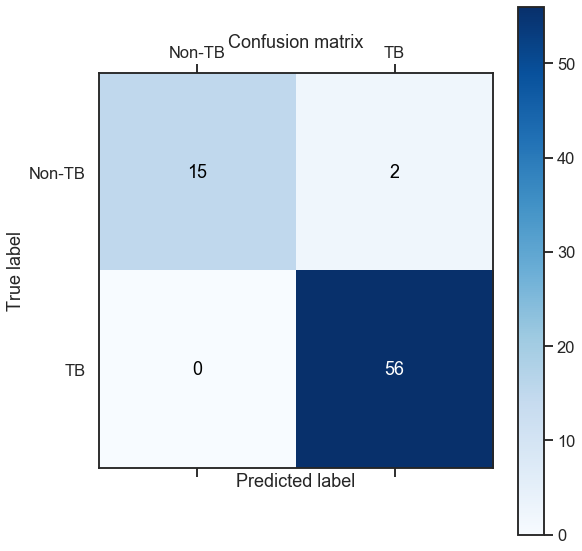

In [19]:
import itertools
import numpy as np
y_pred_out = best_model.predict(data['normalized'].values).reshape(-1)
y_pred = 2 * (y_pred_out > res['cut']) - 1
y_test = data['output'].values


with sns.axes_style('white'):
    sns.set_context("talk")
    ax = plot_confusion_matrix(y_test, y_pred, classes=['Non-TB', 'TB'],
                               title='Confusion matrix')


Text(0.5, 1.0, 'Saída para os dados')

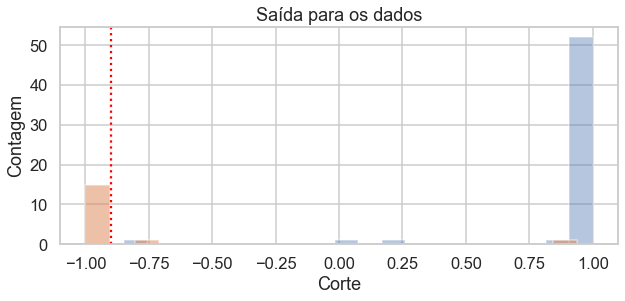

In [20]:
sns.set_context('talk')
sns.set_style('whitegrid')


fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.hist(y_pred_out[np.where(y_test > res['cut'])[0]], alpha=.4, bins=20)
ax.hist(y_pred_out[np.where(y_test < res['cut'])[0]], alpha=.5, bins=20)
ax.axvline(res['cut'], linestyle=':', color='red')
ax.set_xlabel('Corte')
ax.set_ylabel('Contagem')

ax.set_title('Saída para os dados')

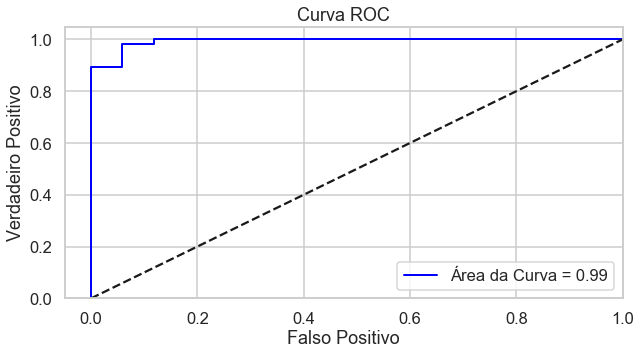

In [21]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
fpr, tpr, _ = roc_curve(y_test, y_pred_out, drop_intermediate=False)
roc_auc = auc(fpr, tpr)
sns.set_context('talk')
sns.set_style('whitegrid')


fig, ax = plt.subplots(1,1, figsize=(10, 5))
lw = 2

ax.plot(fpr, tpr, color='blue',
         lw=lw, label='Área da Curva = %0.2f' % roc_auc)
ax.plot([0, 1], [0, 1], 'k--')

ax.set_xlim([-0.05, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('Falso Positivo')
ax.set_ylabel('Verdadeiro Positivo')
ax.set_title('Curva ROC')
plt.legend(loc="lower right")


In [22]:
data['normalized'].columns

Index(['citometria', 'proteina', 'razaoptn', 'baarliquid', 'amres', 'ada',
       'probtb2', 'cult', 'histopat', 'tipi', 'sorologia', 'pcr', 'probtb3',
       'desfech tb', 'bcg', 'rx', 'asspulm', 'outalt', 'pt', 'dif cit'],
      dtype='object')